We now test pretrained networks, in particular `VGG16` and `VGG19`, thanks to the good results previously obtained with a hand-made *VGG-like* network.

### Fine-tuned VGG16 and VGG19

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [ ]:
%run utils.ipynb

In [ ]:
images, tip_pos = get_dataset(target_size=(224, 224), force_resize=False, rescale_coordinates=100)

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

(513, 224, 224, 3) float32


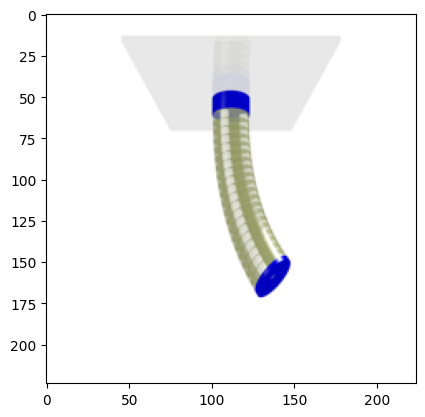

In [ ]:
print(images.shape, images.dtype)
plt.imshow(PIL.Image.fromarray((255 * images[12]).astype(np.uint8)))

In [ ]:
del images

#### VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 11s 170ms/step - loss: 65.2466 - mean_absolute_error: 6.2827 - mean_euclidean_error: 12.7687 - val_loss: 39.3937 - val_mean_absolute_error: 5.2174 - val_mean_euclidean_error: 10.1071
Epoch 2/100
10/10 [==============================] - 0s 35ms/step - loss: 26.6302 - mean_absolute_error: 4.0189 - mean_euclidean_error: 8.1021 - val_loss: 13.1903 - val_mean_absolute_error: 2.7493 - val_mean_euclidean_error: 5.6747
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 12.1711 - mean_absolute_error: 2.7037 - mean_euclidean_error: 5.6621 - val_loss: 11.0514 - val_mean_absolute_error: 2.6345 - val_mean_euclidean_error: 5.4126
Epoch 4/100
10/10 [==============================] - 0s 34ms/step - loss: 6.7614 - mean_absolute_error: 1.9632 - mean_euclidean_error: 4.0299 - val_loss: 7.3912 - val_mean_absolute_error: 2.0236 - val_mean_euclidean_error: 4.0901
Epoch 5/100
10/10 [==============================] - 0s 34ms/step - lo

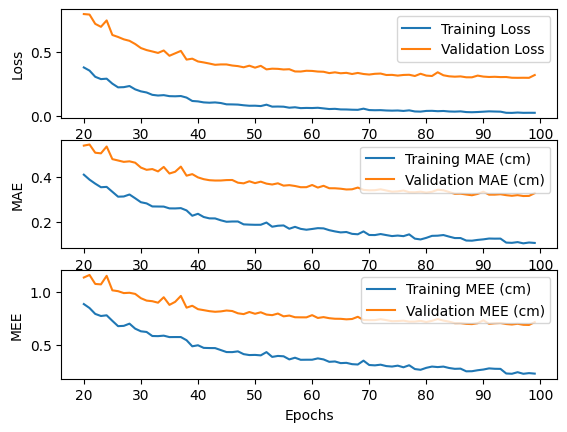

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 23ms/step
103 103 103
103 103 103
x-axis: mean = 0.5594832843760755, std = 3.720719860273965
y-axis: mean = 0.047089425638832526, std = 0.08444377927827292
z-axis: mean = 0.011436187593482161, std = 0.017261174951667804


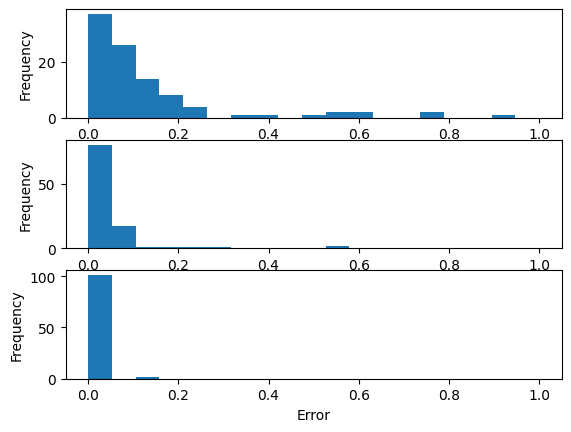

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

As we can see, we got a better performance on the $y$-axis w.r.t. the hand-made VGG, but for the $x$-axis it seems slightly worse, since the standard deviation of relative error is higher than in the hand-made VGG ($3.72$ vs $2.80$).

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.327506422996521
Std of MAE: 0.28349995613098145
Mean of MEE: 0.7132014854217431
Std of MEE: 0.6669909116549451


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.60298252 0.19890755 0.18062914]
Std of Distance along axes: [0.67082504 0.18567142 0.18241192]


In [ ]:
del model

### Fine-tuned VGG19

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 2s 76ms/step - loss: 59.3183 - mean_absolute_error: 6.1872 - mean_euclidean_error: 12.3565 - val_loss: 46.9143 - val_mean_absolute_error: 5.7591 - val_mean_euclidean_error: 11.0151
Epoch 2/100
10/10 [==============================] - 0s 39ms/step - loss: 26.9809 - mean_absolute_error: 4.0937 - mean_euclidean_error: 8.1361 - val_loss: 16.2217 - val_mean_absolute_error: 3.1214 - val_mean_euclidean_error: 6.6131
Epoch 3/100
10/10 [==============================] - 0s 39ms/step - loss: 13.4663 - mean_absolute_error: 2.8304 - mean_euclidean_error: 6.0126 - val_loss: 10.2036 - val_mean_absolute_error: 2.3378 - val_mean_euclidean_error: 4.9645
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 7.6495 - mean_absolute_error: 2.0620 - mean_euclidean_error: 4.2011 - val_loss: 7.6841 - val_mean_absolute_error: 2.0257 - val_mean_euclidean_error: 4.1494
Epoch 5/100
10/10 [==============================] - 0s 38ms/step - loss

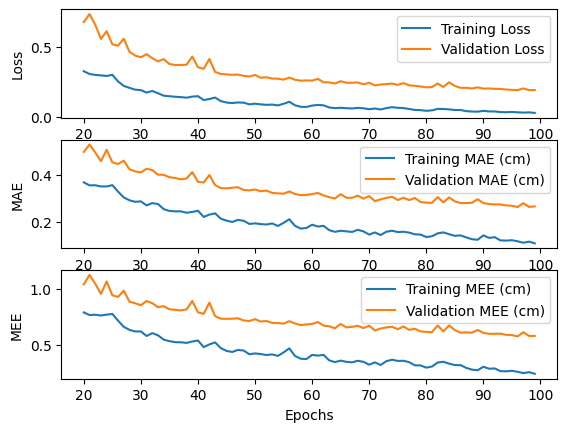

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 0s 26ms/step
103 103 103
103 103 103
x-axis: mean = 0.4083204859113852, std = 1.92663813883883
y-axis: mean = 0.04918610159375562, std = 0.14665534990470042
z-axis: mean = 0.010821113209944045, std = 0.014510829255604294


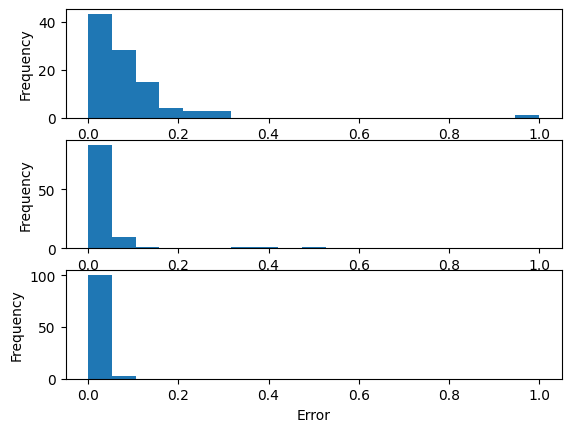

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

In this case we improved performances both on Validation MEE and on the relative error distribution over $x$-axis (std of $1.92$ from $2.80$), while it seems a bit worse over $y$-axis (std of $0.14$ vs $0.08$).

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.26629480719566345
Std of MAE: 0.2237556278705597
Mean of MEE: 0.5784200615033014
Std of MEE: 0.49007714353466125


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.47084429 0.15030862 0.17773145]
Std of Distance along axes: [0.4936825  0.14976631 0.18087986]


In [ ]:
del model